## Semantic segmentation of road for Self-driving Cars

The goal of this project is to segment the image of a road shot from the dashcam of a car. This is a very useful application in Self-driving cars. The dataset that has been used for training the model is 
This dataset provides data images and labeled semantic segmentations captured via CARLA self-driving car simulator. The data was generated as part of the Lyft Udacity Challenge . This dataset can be used to train ML algorithms to identify semantic segmentation of cars, roads etc in an image.
The data has 5 sets of 1000 images and corresponding labels. The labels are also images which have different kinds of objects in the image coloured with a differemnt color.
The pixel value corresponding to '7' indicates the road and hence we will have only those values marked on the image and train our model.

## Approach to solve the problem:

The approach I used to solve this problem was to use a specially desinged CNN which is used for image segmentation known as UNET. This is a phenomenal architecture for performing segmentation tasks and is said to be state-of-the-art for this task.This network takes an image as input and outputs another images as an output of the network. This made me curious to try it out on my own.

## Importing the necessary libraries

In [2]:
from numpy.random import seed
from tqdm.auto import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


## Loading all the images in the directory into image_list and mask_list

In [3]:
import os
image_path_0 = 'data/dataA/dataA/CameraRGB/'
mask_path_0 = 'data/dataA/dataA/CameraSeg/'
image_path_1 = 'data/dataB/dataB/CameraRGB/'
mask_path_1 = 'data/dataB/dataB/CameraSeg/'
image_path_2 = 'data/dataC/dataC/CameraRGB/'
mask_path_2 = 'data/dataC/dataC/CameraSeg/'
image_path_3 = 'data/dataD/dataD/CameraRGB/'
mask_path_3 = 'data/dataD/dataD/CameraSeg/'

image_list_0 = glob.glob(image_path_0+'*.png')
mask_list_0 = glob.glob(mask_path_0+'*.png')


image_list_1 = glob.glob(image_path_1+'*.png')
mask_list_1 = glob.glob(mask_path_1+'*.png')


image_list_2 = glob.glob(image_path_2+'*.png')
mask_list_2 = glob.glob(mask_path_2+'*.png')


image_list_3 = glob.glob(image_path_3+'*.png')
mask_list_3 = glob.glob(mask_path_3+'*.png')


image_list=image_list_0+image_list_1+image_list_2+image_list_3
mask_list=mask_list_0+mask_list_1+mask_list_2+mask_list_3

Text(0.5, 1.0, 'Segmentation')

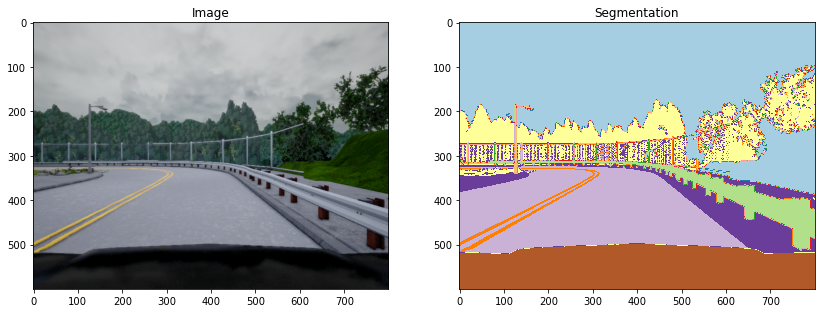

In [90]:
N = 1990
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

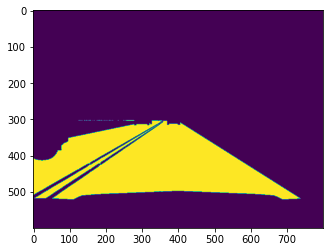

In [5]:
road=np.zeros((600,800))
road[np.where(mask==7)[0],np.where(mask==7)[1]]=1
plt.imshow(road)

## Creating an array of input images and output images

In [13]:
input_images=np.zeros((len(image_list_2),600,800,3))
output_masks=np.zeros((len(image_list_2),600,800))
for m in tqdm(range(len(image_list_2))):
    img=imageio.imread(image_list_2[m])
    input_images[m]=img
    mask=imageio.imread(mask_list_2[m])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
    road=np.zeros((600,800))
    road[np.where(mask==7)[0],np.where(mask==7)]=1
    output_masks[m]=road

## Making the data compatible with the input of the model

In [15]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(output_masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(output_masks)*0.8)]
val_ids = shuffle_ids[int(len(output_masks)*0.8):int(len(output_masks)*0.8+100)]
test_ids = shuffle_ids[int(len(output_masks)*0.8+100):]
train_images, train_masks = input_images[train_ids], output_masks[train_ids]
val_images, val_masks = input_images[val_ids], output_masks[val_ids]
test_images, test_masks = input_images[test_ids], output_masks[test_ids]

In [51]:
train_masks=np.expand_dims(train_masks,3)
test_masks=np.expand_dims(test_masks,3)
val_masks=np.expand_dims(test_masks,3)

In [77]:
test_masks=np.squeeze(test_masks, axis=4)

In [78]:
test_masks.shape

(100, 600, 800, 1)

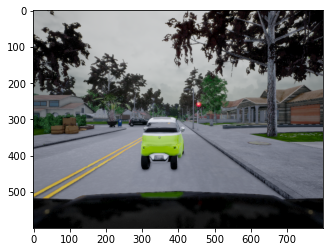

In [148]:
img=imageio.imread(image_list_2[500])
plt.imshow(img)

In [149]:
img.shape

(600, 800, 3)

## Defining a UNET based model for for segmenting the roads

In [79]:
# Build U-Net model
input_img = Input((600,800, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
opti=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opti, loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 600, 800, 8)  584         conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 300, 400, 8)  0           conv2d_32[0][0]                  
____________________________________________________________________________________________

In [60]:
model.load_weights('model-sdc-seg-v2.h5')

In [ ]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v3.h5', verbose=1, save_best_only=True)
]

results = model.fit(train_images, train_masks,batch_size=16, epochs=100, callbacks=callbacks,validation_data=(val_images, val_masks))

## RESULTS :

## The validation loss at the end was about 0.0387 and the train loss was found to be 0.0296. The model was train on Google Cloud Platform and took about 3 hours to train.

In [82]:
model.load_weights('model-sdc-seg-v4.h5')

In [ ]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v4.h5', verbose=1, save_best_only=True)
]

results = model.fit(train_images, train_masks,batch_size=16, epochs=100, callbacks=callbacks,validation_data=(val_images, val_masks))

In [158]:
def plot_test(number):
    my_preds = model.predict(np.expand_dims(test_images[number], 0))
    my_preds = my_preds.flatten()
    my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(my_preds.reshape(600, 800))
    ax[0].set_title('Prediction')
    ax[1].imshow(test_masks[number].reshape(600, 800))
    ax[1].set_title('Ground truth')


## We can see from the below images that that the model seems to be phenomenolly well and has produced a segmented image almost as close to the original label.

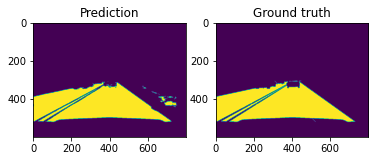

In [159]:
plot_test(55)

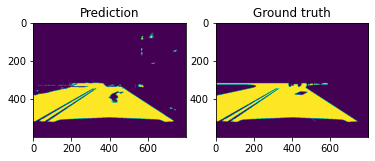

In [122]:
plot_test(69)

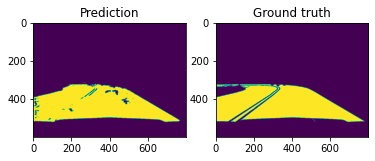

In [123]:
plot_test(74)